<h1>📊 Predicting Boston Housing Prices</h1>
<h2>Collection of Classic Examples</h2>

---
[GitHub Repository](https://github.com/OlgaBelitskaya/machine_learning_engineer_nd009) & [Interactive Version](https://olgabelitskaya.github.io/MLE_ND_P1_SMC.html) & [Interactive Version 2](https://olgabelitskaya.github.io/DL_PP1_Solutions_SMC.html) & [Colaboratory Version](https://colab.research.google.com/drive/1atPu92jNJ-qBsFpbOiMojHGXCu6gJWYW)

In this project, we'll evaluate the performance and predictive power of neural networks in the sphere of regression tasks.
Models will be trained and tested on data collected from homes in suburbs of Boston, Massachusetts.
Origin: This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.
Creators: Harrison, D. and Rubinfeld, D.L.
Data Set Information: Concerns housing values in suburbs of Boston.

<h2>Code Tools</h2>

In [1]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np,sqlite3,os
import seaborn as sn,pylab as pl
import keras as ks,tensorflow as tf
from IPython import display
from sklearn.model_selection import train_test_split
from sklearn import datasets,linear_model,svm
from sklearn.metrics import mean_squared_error,median_absolute_error,\
mean_absolute_error,r2_score,explained_variance_score
from sklearn.tree import DecisionTreeRegressor,ExtraTreeRegressor
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor,\
AdaBoostRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor,RadiusNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,\
QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.kernel_ridge import KernelRidge
from sklearn.cross_decomposition import PLSRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel,RationalQuadratic,RBF
from sklearn.semi_supervised import LabelPropagation,LabelSpreading
from sklearn.isotonic import IsotonicRegression
from keras.datasets import boston_housing
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense,LSTM,GlobalAveragePooling1D
from keras.layers import Activation,Flatten,Dropout,BatchNormalization
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D
from keras.layers.advanced_activations import PReLU,LeakyReLU
fw='weights.boston.hdf5'

Using TensorFlow backend.


In [2]:
def connect_to_db(dbf):
    sqlconn=None
    try:
        sqlconn=sqlite3.connect(dbf)
        return sqlconn
    except Error as err:
        print(err)
        if sqlconn is not None:
            sqlconn.close()
def history_plot(fit_history,n):
    pl.figure(figsize=(12,10))    
    pl.subplot(211)
    pl.plot(fit_history.history['loss'][n:],
            color='slategray',label='train')
    pl.plot(fit_history.history['val_loss'][n:],
            color='#348ABD',label='valid')
    pl.xlabel('Epochs'); pl.ylabel('Loss')
    pl.legend(); pl.title('Loss Function')      
    pl.subplot(212)
    pl.plot(fit_history.history['mae'][n:],
            color='slategray',label='train')
    pl.plot(fit_history.history['val_mae'][n:],
            color='#348ABD',label='valid')
    pl.xlabel('Epochs'); pl.ylabel('MAE')    
    pl.legend(); pl.title('Mean Absolute Error')
    pl.show()
def nnpredict(y1,y2,y3,ti):
    pl.figure(figsize=(12,6))
    pl.scatter(range(n),y_test[:n],marker='*',s=100,
               color='black',label='Real data')
    pl.plot(y1[:n],label='MLP')
    pl.plot(y2[:n],label='CNN')
    pl.plot(y3[:n],label='RNN')
    pl.xlabel("Data Points")
    pl.ylabel("Predicted and Real Target Values")
    pl.legend(); pl.title(ti); pl.show()

<h2>Data Loading and Exploration</h2>

In [3]:
connection=connect_to_db('boston.db')
if connection is not None:
    cursor=connection.cursor()
boston_data=datasets.load_boston()
columns=boston_data.feature_names
boston_df=pd.DataFrame(boston_data.data,columns=columns)
boston_df['MEDV']=boston_data.target
boston_df.to_sql('main',con=connection,if_exists='replace')
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
pearson=boston_df.corr(method='pearson')
corr_with_prices=pearson.iloc[-int(1)][:-int(1)]
pd.DataFrame(corr_with_prices[abs(corr_with_prices)\
             .argsort()[::-int(1)]])

,MEDV
LSTAT,-0.737663
RM,0.695360
PTRATIO,-0.507787
INDUS,-0.483725
TAX,-0.468536
NOX,-0.427321
CRIM,-0.388305
RAD,-0.381626
AGE,-0.376955
ZN,0.360445


In [5]:
pd.read_sql_query('''
SELECT ZN,
       AVG(LSTAT),
       AVG(RM),
       AVG(PTRATIO),
       AVG(INDUS),
       AVG(TAX)
FROM main
GROUP BY ZN;
''',con=connection)\
.set_index('ZN').head(int(7))

,AVG(LSTAT),AVG(RM),AVG(PTRATIO),AVG(INDUS),AVG(TAX)
ZN,,,,,
0.0,14.447366,6.147922,19.057796,13.542231,449.182796
12.5,15.802000,5.945100,16.310000,7.330000,321.200000
17.5,8.050000,7.104000,18.600000,1.380000,216.000000
18.0,4.980000,6.575000,15.300000,2.310000,296.000000
20.0,7.691429,7.160190,14.695238,4.560000,245.095238
21.0,9.147500,6.146750,16.800000,5.640000,243.000000
22.0,8.291000,6.482400,19.100000,5.860000,330.000000


In [6]:
if connection is not None:
    connection.close()
if os.path.exists('boston.db'):
    os.remove('boston.db')
else:
    print('The file does not exist')
os.listdir()

['__notebook__.ipynb']

In [7]:
n=int(51)
(x_train,y_train),(x_test,y_test)=boston_housing.load_data()
x_valid,y_valid=x_test[:n],y_test[:n]
x_test,y_test=x_test[n:],y_test[n:]
t=[["Training feature's shape:",x_train.shape],
   ["Training target's shape",y_train.shape],
   ["Validating feature's shape:",x_valid.shape],
   ["Validating target's shape",y_valid.shape],
   ["Testing feature's shape:",x_test.shape],
   ["Testing target's shape",y_test.shape]]
pd.DataFrame(t)

57344/57026 [==============================] - 0s 0us/step


,0,1
0,Training feature's shape:,"(404, 13)"
1,Training target's shape,"(404,)"
2,Validating feature's shape:,"(51, 13)"
3,Validating target's shape,"(51,)"
4,Testing feature's shape:,"(51, 13)"
5,Testing target's shape,"(51,)"


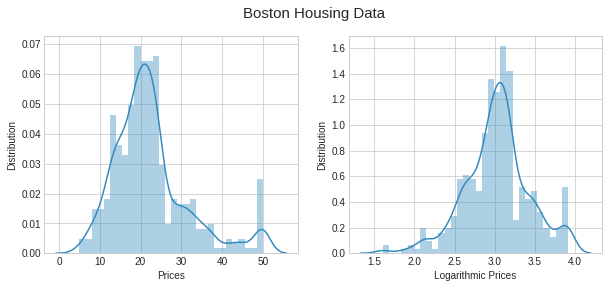

In [8]:
pl.style.use('seaborn-whitegrid')
pl.figure(1,figsize=(10,4))
pl.subplot(121)
sn.distplot(y_train,color='#348ABD',bins=30)
pl.ylabel("Distribution"); pl.xlabel("Prices")
pl.subplot(122)
sn.distplot(np.log(y_train),color='#348ABD',bins=30)
pl.ylabel("Distribution"); pl.xlabel("Logarithmic Prices")
pl.suptitle('Boston Housing Data',fontsize=15)
pl.show()

 <h2>Building Neural Networks with Keras Py</h2>

In [9]:
def mlp_model():
    model=Sequential() 
    model.add(Dense(832,input_dim=13))
    model.add(LeakyReLU(alpha=.025))   
    model.add(Dense(104))     
    model.add(LeakyReLU(alpha=.025))   
    model.add(Dense(1,kernel_initializer='normal'))    
    model.compile(loss='mse',optimizer='rmsprop',metrics=['mae'])
    return model
mlp_model=mlp_model()
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=10,
                               verbose=0,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=20,verbose=2)
history=mlp_model.fit(x_train,y_train,batch_size=24, 
                      validation_data=(x_valid,y_valid),
                      epochs=1000,verbose=2, 
                      callbacks=[checkpointer,lr_reduction,estopping])

Train on 404 samples, validate on 51 samples
Epoch 1/1000
 - 0s - loss: 274.7510 - mae: 10.6322 - val_loss: 49.8812 - val_mae: 4.9054

Epoch 00001: val_loss improved from inf to 49.88120, saving model to weights.boston.hdf5
Epoch 2/1000
 - 0s - loss: 103.1095 - mae: 7.7739 - val_loss: 43.6695 - val_mae: 4.7077

Epoch 00002: val_loss improved from 49.88120 to 43.66951, saving model to weights.boston.hdf5
Epoch 3/1000
 - 0s - loss: 98.6216 - mae: 7.5639 - val_loss: 54.9449 - val_mae: 5.9499

Epoch 00003: val_loss did not improve from 43.66951
Epoch 4/1000
 - 0s - loss: 83.1082 - mae: 6.8849 - val_loss: 64.5551 - val_mae: 5.7448

Epoch 00004: val_loss did not improve from 43.66951
Epoch 5/1000
 - 0s - loss: 80.6509 - mae: 6.7522 - val_loss: 43.6005 - val_mae: 4.7263

Epoch 00005: val_loss improved from 43.66951 to 43.60047, saving model to weights.boston.hdf5
Epoch 6/1000
 - 0s - loss: 74.6317 - mae: 6.2722 - val_loss: 60.7518 - val_mae: 5.6118

Epoch 00006: val_loss did not improve from 

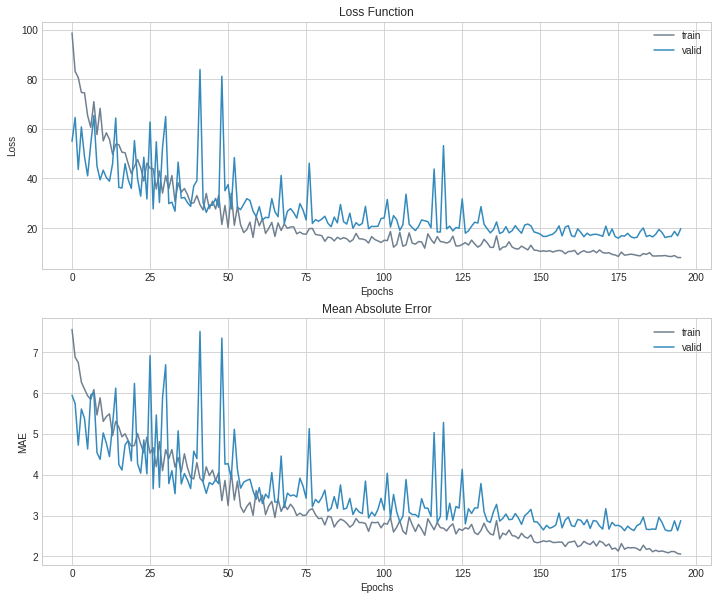

,0,1
0,Train R2 score:,0.891108
1,Valid R2 score:,0.763665
2,Test R2 score:,0.639533


In [10]:
history_plot(history,2)
mlp_model.load_weights(fw)
y_train_mlp=mlp_model.predict(x_train)
y_valid_mlp=mlp_model.predict(x_valid)
y_test_mlp=mlp_model.predict(x_test)
score_train_mlp=r2_score(y_train,y_train_mlp)
score_valid_mlp=r2_score(y_valid,y_valid_mlp)
score_test_mlp=r2_score(y_test,y_test_mlp)
pd.DataFrame([['Train R2 score:',score_train_mlp],
              ['Valid R2 score:',score_valid_mlp],
              ['Test R2 score:',score_test_mlp]])

In [11]:
def cnn_model():
    model=Sequential()       
    model.add(Conv1D(13,5,padding='valid',
                     input_shape=(13,1)))
    model.add(LeakyReLU(alpha=.025))
    model.add(MaxPooling1D(pool_size=2))   
    model.add(Conv1D(128,3,padding='valid'))
    model.add(LeakyReLU(alpha=.025))
    model.add(MaxPooling1D(pool_size=2))   
    model.add(Flatten())      
    model.add(Dense(26,activation='relu',
                    kernel_initializer='normal'))
    model.add(Dropout(.1))  
    model.add(Dense(1,kernel_initializer='normal'))  
    model.compile(loss='mse',optimizer='nadam',metrics=['mae'])
    return model
cnn_model=cnn_model()
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=10,
                               verbose=0,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=20,verbose=2)
history=cnn_model.fit(x_train.reshape(-1,13,1),y_train, 
                          validation_data=(x_valid.reshape(-1,13,1),y_valid),
                          epochs=1000,batch_size=14,verbose=2, 
                          callbacks=[checkpointer,lr_reduction,estopping])

Train on 404 samples, validate on 51 samples
Epoch 1/1000
 - 0s - loss: 201.9437 - mae: 11.1119 - val_loss: 87.7924 - val_mae: 7.0763

Epoch 00001: val_loss improved from inf to 87.79238, saving model to weights.boston.hdf5
Epoch 2/1000
 - 0s - loss: 89.9808 - mae: 6.8325 - val_loss: 53.0955 - val_mae: 5.3669

Epoch 00002: val_loss improved from 87.79238 to 53.09545, saving model to weights.boston.hdf5
Epoch 3/1000
 - 0s - loss: 78.4433 - mae: 6.4511 - val_loss: 63.5969 - val_mae: 5.6077

Epoch 00003: val_loss did not improve from 53.09545
Epoch 4/1000
 - 0s - loss: 77.5726 - mae: 6.4696 - val_loss: 50.9646 - val_mae: 5.3535

Epoch 00004: val_loss improved from 53.09545 to 50.96462, saving model to weights.boston.hdf5
Epoch 5/1000
 - 0s - loss: 73.4828 - mae: 6.1155 - val_loss: 49.9115 - val_mae: 5.3176

Epoch 00005: val_loss improved from 50.96462 to 49.91145, saving model to weights.boston.hdf5
Epoch 6/1000
 - 0s - loss: 68.9554 - mae: 6.0472 - val_loss: 54.2047 - val_mae: 5.2369

Ep

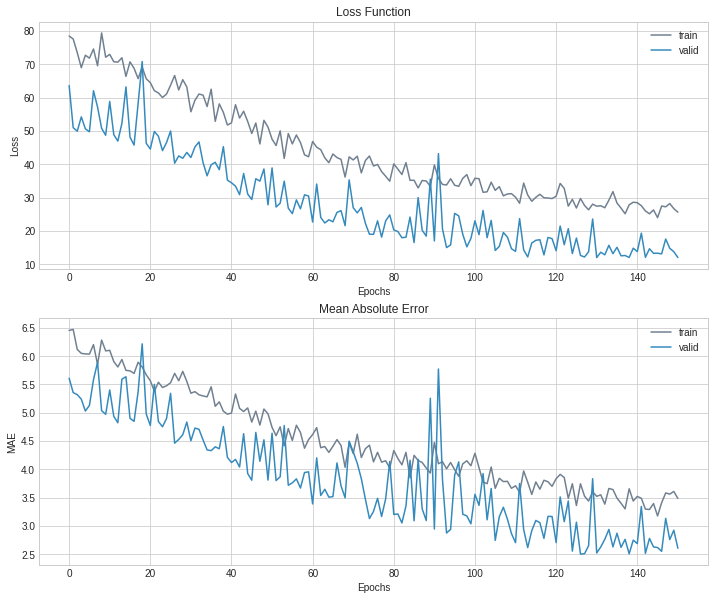

,0,1
0,Train R2 score:,0.765191
1,Valid R2 score:,0.821834
2,Test R2 score:,0.700359


In [12]:
history_plot(history,2)
cnn_model.load_weights(fw)
y_train_cnn=cnn_model.predict(x_train.reshape(-1,13,1))
y_valid_cnn=cnn_model.predict(x_valid.reshape(-1,13,1))
y_test_cnn=cnn_model.predict(x_test.reshape(-1,13,1))
score_train_cnn=r2_score(y_train,y_train_cnn)
score_valid_cnn=r2_score(y_valid,y_valid_cnn)
score_test_cnn=r2_score(y_test,y_test_cnn)
pd.DataFrame([['Train R2 score:',score_train_cnn],
              ['Valid R2 score:',score_valid_cnn],
              ['Test R2 score:',score_test_cnn]])

In [13]:
def rnn_model():
    model=Sequential()   
    model.add(LSTM(104,return_sequences=True,
                   input_shape=(1,13)))
    model.add(LSTM(104,return_sequences=True))
    model.add(LSTM(104,return_sequences=False))   
    model.add(Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])       
    return model
rnn_model=rnn_model()
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=10,
                               verbose=0,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=20,verbose=2)
history=rnn_model.fit(x_train.reshape(-1,1,13),y_train, 
                          validation_data=(x_valid.reshape(-1,1,13),y_valid),
                          epochs=1000,batch_size=16,verbose=2, 
                          callbacks=[checkpointer,lr_reduction,estopping])

Train on 404 samples, validate on 51 samples
Epoch 1/1000
 - 2s - loss: 410.6869 - mae: 17.6140 - val_loss: 216.5145 - val_mae: 12.5030

Epoch 00001: val_loss improved from inf to 216.51454, saving model to weights.boston.hdf5
Epoch 2/1000
 - 0s - loss: 180.1909 - mae: 10.2342 - val_loss: 137.1588 - val_mae: 9.3543

Epoch 00002: val_loss improved from 216.51454 to 137.15879, saving model to weights.boston.hdf5
Epoch 3/1000
 - 0s - loss: 133.6120 - mae: 8.3411 - val_loss: 104.4547 - val_mae: 7.8491

Epoch 00003: val_loss improved from 137.15879 to 104.45471, saving model to weights.boston.hdf5
Epoch 4/1000
 - 0s - loss: 108.8373 - mae: 7.1984 - val_loss: 82.7521 - val_mae: 6.5145

Epoch 00004: val_loss improved from 104.45471 to 82.75210, saving model to weights.boston.hdf5
Epoch 5/1000
 - 0s - loss: 92.6112 - mae: 6.4628 - val_loss: 68.5780 - val_mae: 5.5924

Epoch 00005: val_loss improved from 82.75210 to 68.57802, saving model to weights.boston.hdf5
Epoch 6/1000
 - 0s - loss: 82.2155

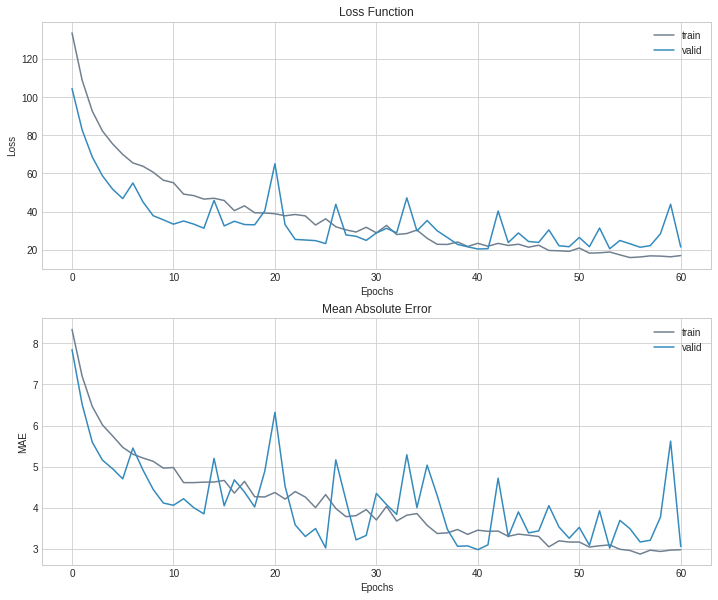

,0,1
0,Train R2 score:,0.761397
1,Valid R2 score:,0.697783
2,Test R2 score:,0.664646


In [14]:
history_plot(history,2)
rnn_model.load_weights(fw)
y_train_rnn=rnn_model.predict(x_train.reshape(-1,1,13))
y_valid_rnn=rnn_model.predict(x_valid.reshape(-1,1,13))
y_test_rnn=rnn_model.predict(x_test.reshape(-1,1,13))
score_train_rnn=r2_score(y_train,y_train_rnn)
score_valid_rnn=r2_score(y_valid,y_valid_rnn)
score_test_rnn=r2_score(y_test,y_test_rnn)
pd.DataFrame([['Train R2 score:',score_train_rnn],
              ['Valid R2 score:',score_valid_rnn],
              ['Test R2 score:',score_test_rnn]])

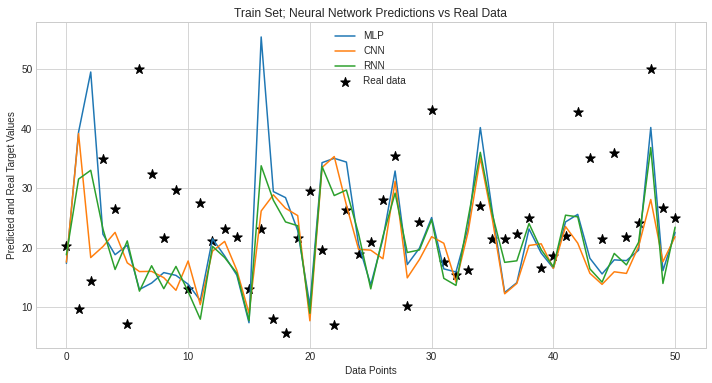

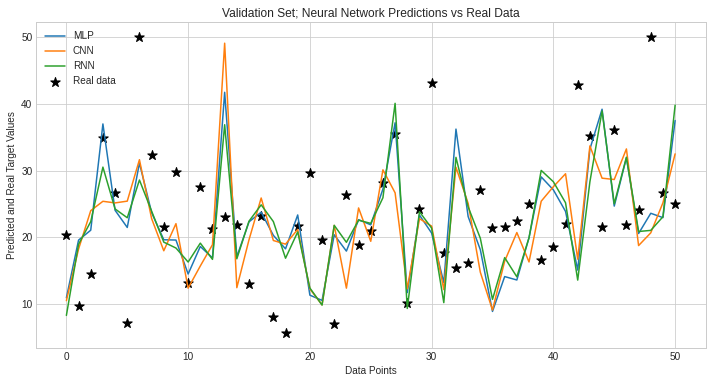

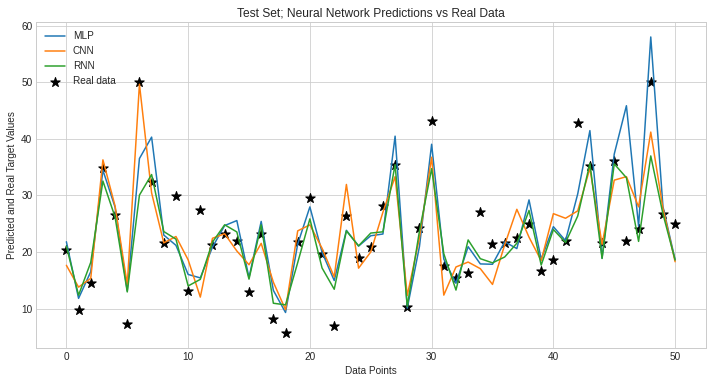

In [15]:
ti="Train Set; Neural Network Predictions vs Real Data"
y1,y2,y3=y_train_mlp,y_train_cnn,y_train_rnn
nnpredict(y1,y2,y3,ti)
ti="Validation Set; Neural Network Predictions vs Real Data"
y1,y2,y3=y_valid_mlp,y_valid_cnn,y_valid_rnn
nnpredict(y1,y2,y3,ti)
ti="Test Set; Neural Network Predictions vs Real Data"
y1,y2,y3=y_test_mlp,y_test_cnn,y_test_rnn
nnpredict(y1,y2,y3,ti)

<h2>Compare with Sklearn Algorithms Py</h2>

In [16]:
def regressor_fit_score(regressor,regressor_name,dataset,
                        x_train,x_test,y_train,y_test,n=6):
    regressor_list.append(str(regressor))
    regressor_names.append(regressor_name)
    reg_datasets.append(dataset)    
    regressor.fit(x_train,y_train)
    y_reg_train=regressor.predict(x_train)
    y_reg_test=regressor.predict(x_test)    
    r2_reg_train=round(r2_score(y_train,y_reg_train),n)
    r2_train.append(r2_reg_train)
    r2_reg_test=round(r2_score(y_test,y_reg_test),n)
    r2_test.append(r2_reg_test)    
    ev_reg_train=round(explained_variance_score(y_train,y_reg_train),n)
    ev_train.append(ev_reg_train)
    ev_reg_test=round(explained_variance_score(y_test, y_reg_test),n)
    ev_test.append(ev_reg_test)    
    mse_reg_train=round(mean_squared_error(y_train,y_reg_train),n)
    mse_train.append(mse_reg_train)
    mse_reg_test=round(mean_squared_error(y_test,y_reg_test),n)
    mse_test.append(mse_reg_test)
    mae_reg_train=round(mean_absolute_error(y_train,y_reg_train),n)
    mae_train.append(mae_reg_train)
    mae_reg_test=round(mean_absolute_error(y_test,y_reg_test),n)
    mae_test.append(mae_reg_test)
    mdae_reg_train=round(median_absolute_error(y_train,y_reg_train),n)
    mdae_train.append(mdae_reg_train)
    mdae_reg_test=round(median_absolute_error(y_test,y_reg_test),n)
    mdae_test.append(mdae_reg_test)    
    return [y_reg_train,y_reg_test,r2_reg_train,r2_reg_test,
            ev_reg_train,ev_reg_test,
            mse_reg_train,mse_reg_test,mae_reg_train,mae_reg_test,
            mdae_reg_train,mdae_reg_test]
def get_regressor_results():
    return pd.DataFrame({'regressor':regressor_list,
                         'regressor_name':regressor_names,
                         'dataset':reg_datasets,
                         'r2_train':r2_train,'r2_test':r2_test,
                         'ev_train':ev_train,'ev_test':ev_test,
                         'mse_train':mse_train,'mse_test':mse_test,
                         'mae_train':mae_train,'mae_test':mae_test,
                         'mdae_train':mdae_train,'mdae_test':mdae_test})

In [17]:
(x_train,y_train),(x_test,y_test)=boston_housing.load_data()
regressor_list,regressor_names,reg_datasets=[],[],[]
r2_train,r2_test,ev_train, ev_test,mse_train,mse_test,mae_train,\
mae_test,mdae_train,mdae_test=[],[],[],[],[],[],[],[],[],[]
df_list=['regressor_name','r2_train','r2_test','ev_train','ev_test',
         'mse_train','mse_test','mae_train','mae_test',
         'mdae_train','mdae_test']
reg=[linear_model.LinearRegression(),
     linear_model.Ridge(),linear_model.RidgeCV(),
     linear_model.Lasso(),linear_model.LassoLarsCV(),
     linear_model.RANSACRegressor(),
     linear_model.BayesianRidge(),linear_model.ARDRegression(),
     linear_model.HuberRegressor(),linear_model.TheilSenRegressor(),
     PLSRegression(),DecisionTreeRegressor(),ExtraTreeRegressor(),
     BaggingRegressor(),AdaBoostRegressor(),
     GradientBoostingRegressor(),RandomForestRegressor(),
     linear_model.PassiveAggressiveRegressor(max_iter=1000,tol=.001),
     linear_model.ElasticNet(),
     linear_model.SGDRegressor(max_iter=1000,tol=.001),
     svm.SVR(),KNeighborsRegressor(),
     RadiusNeighborsRegressor(radius=1.5),GaussianProcessRegressor()]
listreg=['LinearRegression','Ridge','RidgeCV',
         'Lasso','LassoLarsCV','RANSACRegressor',
         'BayesianRidge','ARDRegression','HuberRegressor',
         'TheilSenRegressor','PLSRegression','DecisionTreeRegressor',
         'ExtraTreeRegressor','BaggingRegressor','AdaBoostRegressor',
         'GradientBoostingRegressor','RandomForestRegressor']

In [18]:
yreg=[]
for i in range(len(listreg)):
    yreg.append(regressor_fit_score(reg[i],listreg[i],'Boston',
                                    x_train,x_test,
                                    y_train,y_test)[:2])
[[y_train101,y_test101],[y_train102,y_test102],[y_train103,y_test103],
 [y_train104,y_test104],[y_train105,y_test105],[y_train106,y_test106],
 [y_train107,y_test107],[y_train108,y_test108],[y_train109,y_test109],
 [y_train110,y_test110],[y_train111,y_test111],[y_train112,y_test112],
 [y_train113,y_test113],[y_train114,y_test114],[y_train115,y_test115],
 [y_train116,y_test116],[y_train117,y_test117]]=yreg

In [19]:
df_regressor_results=get_regressor_results()
df_regressor_results.to_csv('regressor_results.csv')
df_regressor_results[df_list].sort_values('r2_test',ascending=False)

,regressor_name,r2_train,r2_test,ev_train,ev_test,mse_train,mse_test,mae_train,mae_test,mdae_train,mdae_test
15,GradientBoostingRegressor,0.980074,0.844714,0.980074,0.845254,1.686211,12.926576,1.029679,2.342935,0.911659,1.561932
13,BaggingRegressor,0.978835,0.843221,0.978848,0.844428,1.791019,13.050887,0.866460,2.426961,0.565000,1.595000
16,RandomForestRegressor,0.984409,0.826214,0.984422,0.827215,1.319357,14.466656,0.801015,2.488373,0.567500,1.786500
12,ExtraTreeRegressor,1.000000,0.800931,1.000000,0.806161,0.000000,16.571275,0.000000,3.026471,0.000000,2.200000
11,DecisionTreeRegressor,1.000000,0.775978,1.000000,0.776123,0.000000,18.648431,0.000000,3.207843,0.000000,2.400000
9,TheilSenRegressor,0.696666,0.761652,0.702241,0.768165,25.668799,19.841024,3.178944,3.202298,2.031289,2.170313
14,AdaBoostRegressor,0.907559,0.759671,0.911639,0.759813,7.822526,20.005931,2.293089,3.308933,2.144149,2.578196
10,PLSRegression,0.698820,0.736499,0.698820,0.736808,25.486528,21.934800,3.379702,3.448051,2.282466,2.830008
6,BayesianRidge,0.726385,0.735998,0.726385,0.736479,23.153945,21.976523,3.370268,3.387420,2.407641,2.199119
1,Ridge,0.736891,0.729131,0.736891,0.729157,22.264871,22.548159,3.328195,3.402405,2.481513,2.479757


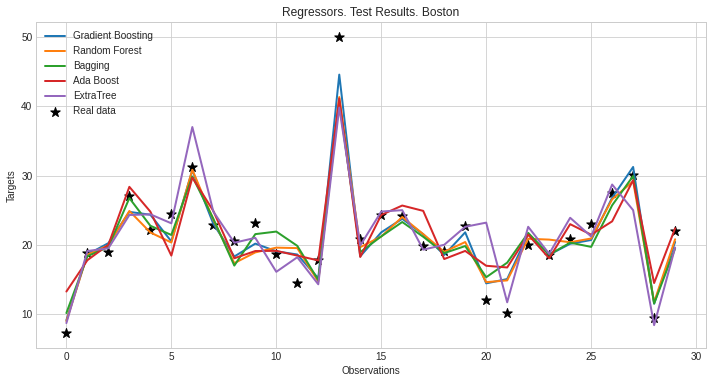

In [20]:
pl.figure(figsize=(12,6)); n=30; x=range(n)
pl.scatter(x,y_test[:n],marker='*',s=100,
           color='black',label='Real data')
pl.plot(x,y_test116[:n],lw=2,label='Gradient Boosting')
pl.plot(x,y_test117[:n],lw=2,label='Random Forest')
pl.plot(x,y_test114[:n],lw=2,label='Bagging')
pl.plot(x,y_test115[:n],lw=2,label='Ada Boost')
pl.plot(x,y_test113[:n],lw=2,label='ExtraTree')
pl.xlabel('Observations'); pl.ylabel('Targets')
pl.title('Regressors. Test Results. Boston')
pl.legend(loc=2,fontsize=10); pl.show()